Processed 280653 data points
Position range: -509 to 509
Fragment size range: 40 to 500


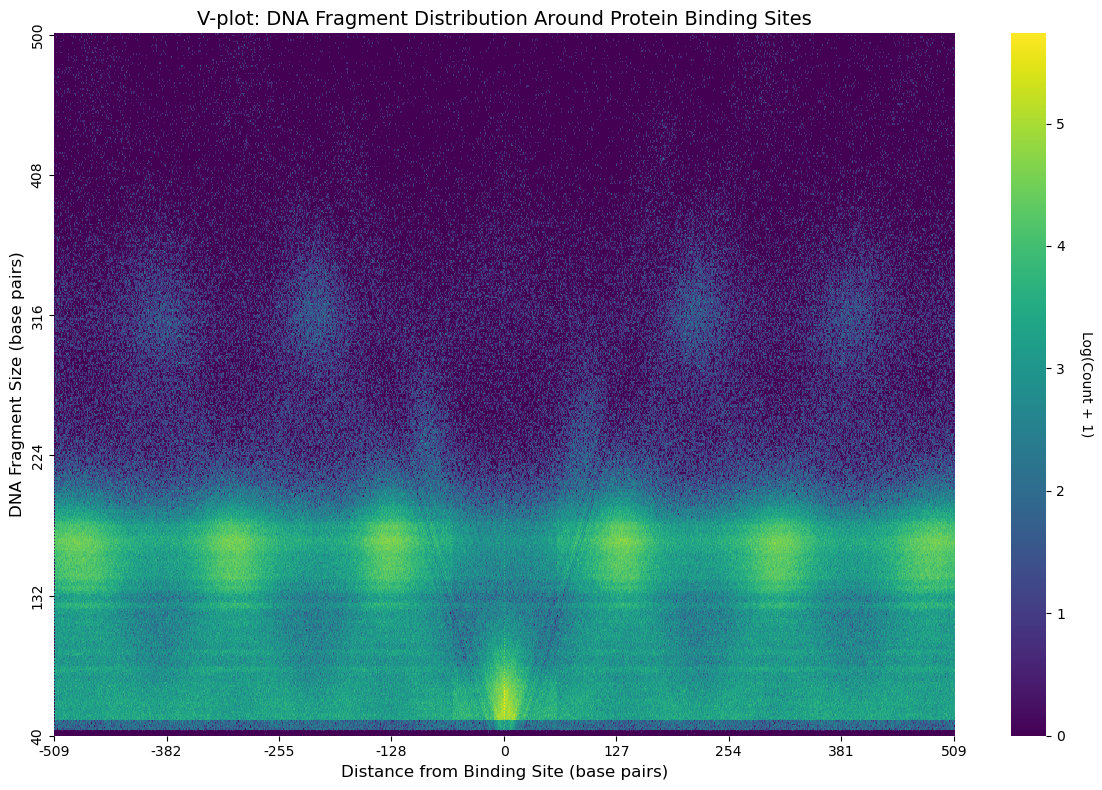

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip

def create_vplot_visualization(input_data_path, max_distance=1000, max_fragment_size=500):
    position_fragment_counts = defaultdict(int)
    
    with gzip.open(input_data_path, 'rt') as data_file:
        for record_number, data_line in enumerate(data_file, 1):
            try:
                columns = data_line.strip().split('\t')
                
                protein_midpoint = (int(columns[2]) + int(columns[3])) / 2
                fragment_midpoint = (int(columns[8]) + int(columns[9])) / 2
                
                # Compute relative position and fragment length
                relative_position = int(fragment_midpoint - protein_midpoint)
                fragment_length = int(columns[9]) - int(columns[8])
                
                # Filter based on specified ranges
                if (abs(relative_position) <= max_distance and 
                    fragment_length <= max_fragment_size):
                    position_fragment_counts[(relative_position, fragment_length)] += 1
                    
            except (IndexError, ValueError) as error:
                print(f"Warning: Skipping record {record_number}: {error}")
                continue
    
    unique_positions = sorted({pos for pos, _ in position_fragment_counts.keys()})
    unique_lengths = sorted({length for _, length in position_fragment_counts.keys()})
    
    print(f"Processed {len(position_fragment_counts)} data points")
    print(f"Position range: {min(unique_positions)} to {max(unique_positions)}")
    print(f"Fragment size range: {min(unique_lengths)} to {max(unique_lengths)}")
    
    density_matrix = np.zeros((len(unique_lengths), len(unique_positions)))
    
    for row_idx, frag_size in enumerate(unique_lengths):
        for col_idx, position in enumerate(unique_positions):
            density_matrix[row_idx, col_idx] = position_fragment_counts.get(
                (position, frag_size), 0)
    
    return unique_positions, unique_lengths, density_matrix

try:
    data_file_path = "mapped.bed.gz"
    positions, fragment_sizes, density_data = create_vplot_visualization(data_file_path)
    plt.figure(figsize=(12, 8))
    log_density = np.log1p(density_data)
    
    heatmap = sns.heatmap(log_density, cmap='viridis', 
                         xticklabels=500, yticklabels=50)
    
    x_tick_positions = np.linspace(0, len(positions)-1, 9).astype(int)
    x_tick_labels = [positions[idx] for idx in x_tick_positions]
    plt.xticks(x_tick_positions, x_tick_labels)

    y_tick_positions = np.linspace(0, len(fragment_sizes)-1, 6).astype(int)
    y_tick_labels = [fragment_sizes[idx] for idx in y_tick_positions]
    plt.yticks(y_tick_positions, y_tick_labels)
    
    plt.xlabel('Distance from Binding Site (base pairs)', fontsize=12)
    plt.ylabel('DNA Fragment Size (base pairs)', fontsize=12)
    plt.title('V-plot: DNA Fragment Distribution Around Protein Binding Sites', 
              fontsize=14)
    
    plt.gca().invert_yaxis()
    
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_label('Log(Count + 1)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"Error: Input file '{data_file_path}' not found")
except Exception as error:
    print(f"Error during visualization creation: {str(error)}")